# Feature Correlation Analysis

This notebook analyzes the correlation between gene expression and copy number variation. Samples are split into subgroups (normal, amplified, deleted) to isolate any patterns in gene expression data related to copy number status.

The following samples are used:
- C3L-02705-71
- C3N-00148-01
- C3N-00148-04

Note that there is a class imbalance among the samples where normal and amplified results are much more strongly represented than deleted.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, kstest

Retrieve copy number and gene expression data for each sample:

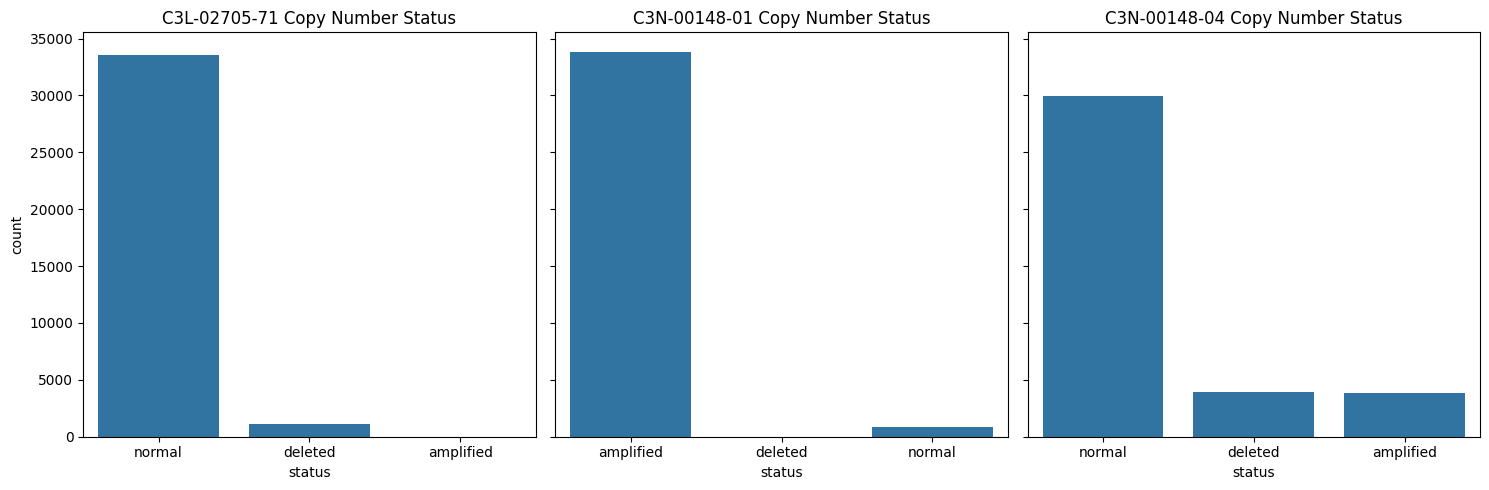

In [2]:
s1_case_id = 'C3L-02705-71'
s2_case_id = 'C3N-00148-01'
s3_case_id = 'C3N-00148-04'

# load datasets
s1_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3L-02705-71.csv')
s2_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-01.csv')
s3_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-04.csv')

# drop rows with zeroed stats
s1_df = s1_df[(s1_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]
s2_df = s2_df[(s2_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]
s3_df = s3_df[(s3_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]

# set up figure and axes for plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot for sample 1
sns.countplot(data=s1_df, x='status', ax=axes[0])
axes[0].set_title(f'{s1_case_id} Copy Number Status')

# plot for sample 2
sns.countplot(data=s2_df, x='status', ax=axes[1])
axes[1].set_title(f'{s2_case_id} Copy Number Status')

# plot for sample 3
sns.countplot(data=s3_df, x='status', ax=axes[2])
axes[2].set_title(f'{s3_case_id} Copy Number Status')

# side by side display
plt.tight_layout()
plt.show()

Description lists for plots

In [3]:
samples = [s1_df, s2_df, s3_df]
sample_names = ["s1", "s2", "s3"]
stats = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
dev_stats = ['dev_gene_expr_normalized_mean', 'dev_mean_gene_expr_normalized_mean', 'dev_variance_gene_expr_normalized_mean']

# status to color mapping
status_colors = {
    "normal": "green",
    "amplified": "blue",
    "deleted": "red"
}

Interquartile range calculation to remove outliers

In [4]:
# helper function to remove outliers via IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

## Gene expression sum, mean, variance (post-log transform)

- Separate histograms are created for clearer view of the varying distribution ranges Displaying log transformed distributions.
- The `split_stats` dictionary is also used to track each feature's raw values as they appear in the plots. Keys names are based on the sample, CNV status, and statistic. Values are the contents of the feature (column) for a specific CNV status (normal/amplified/deleted) in a sample. This dictionary is used for K-S tests.

Keys:
- **Samples**: s1, s2, or s3
- **CNV status**: normal, amplified, deleted
- **Statistic**: sum_gene_expr, mean_gene_expr, variance_gene_expr

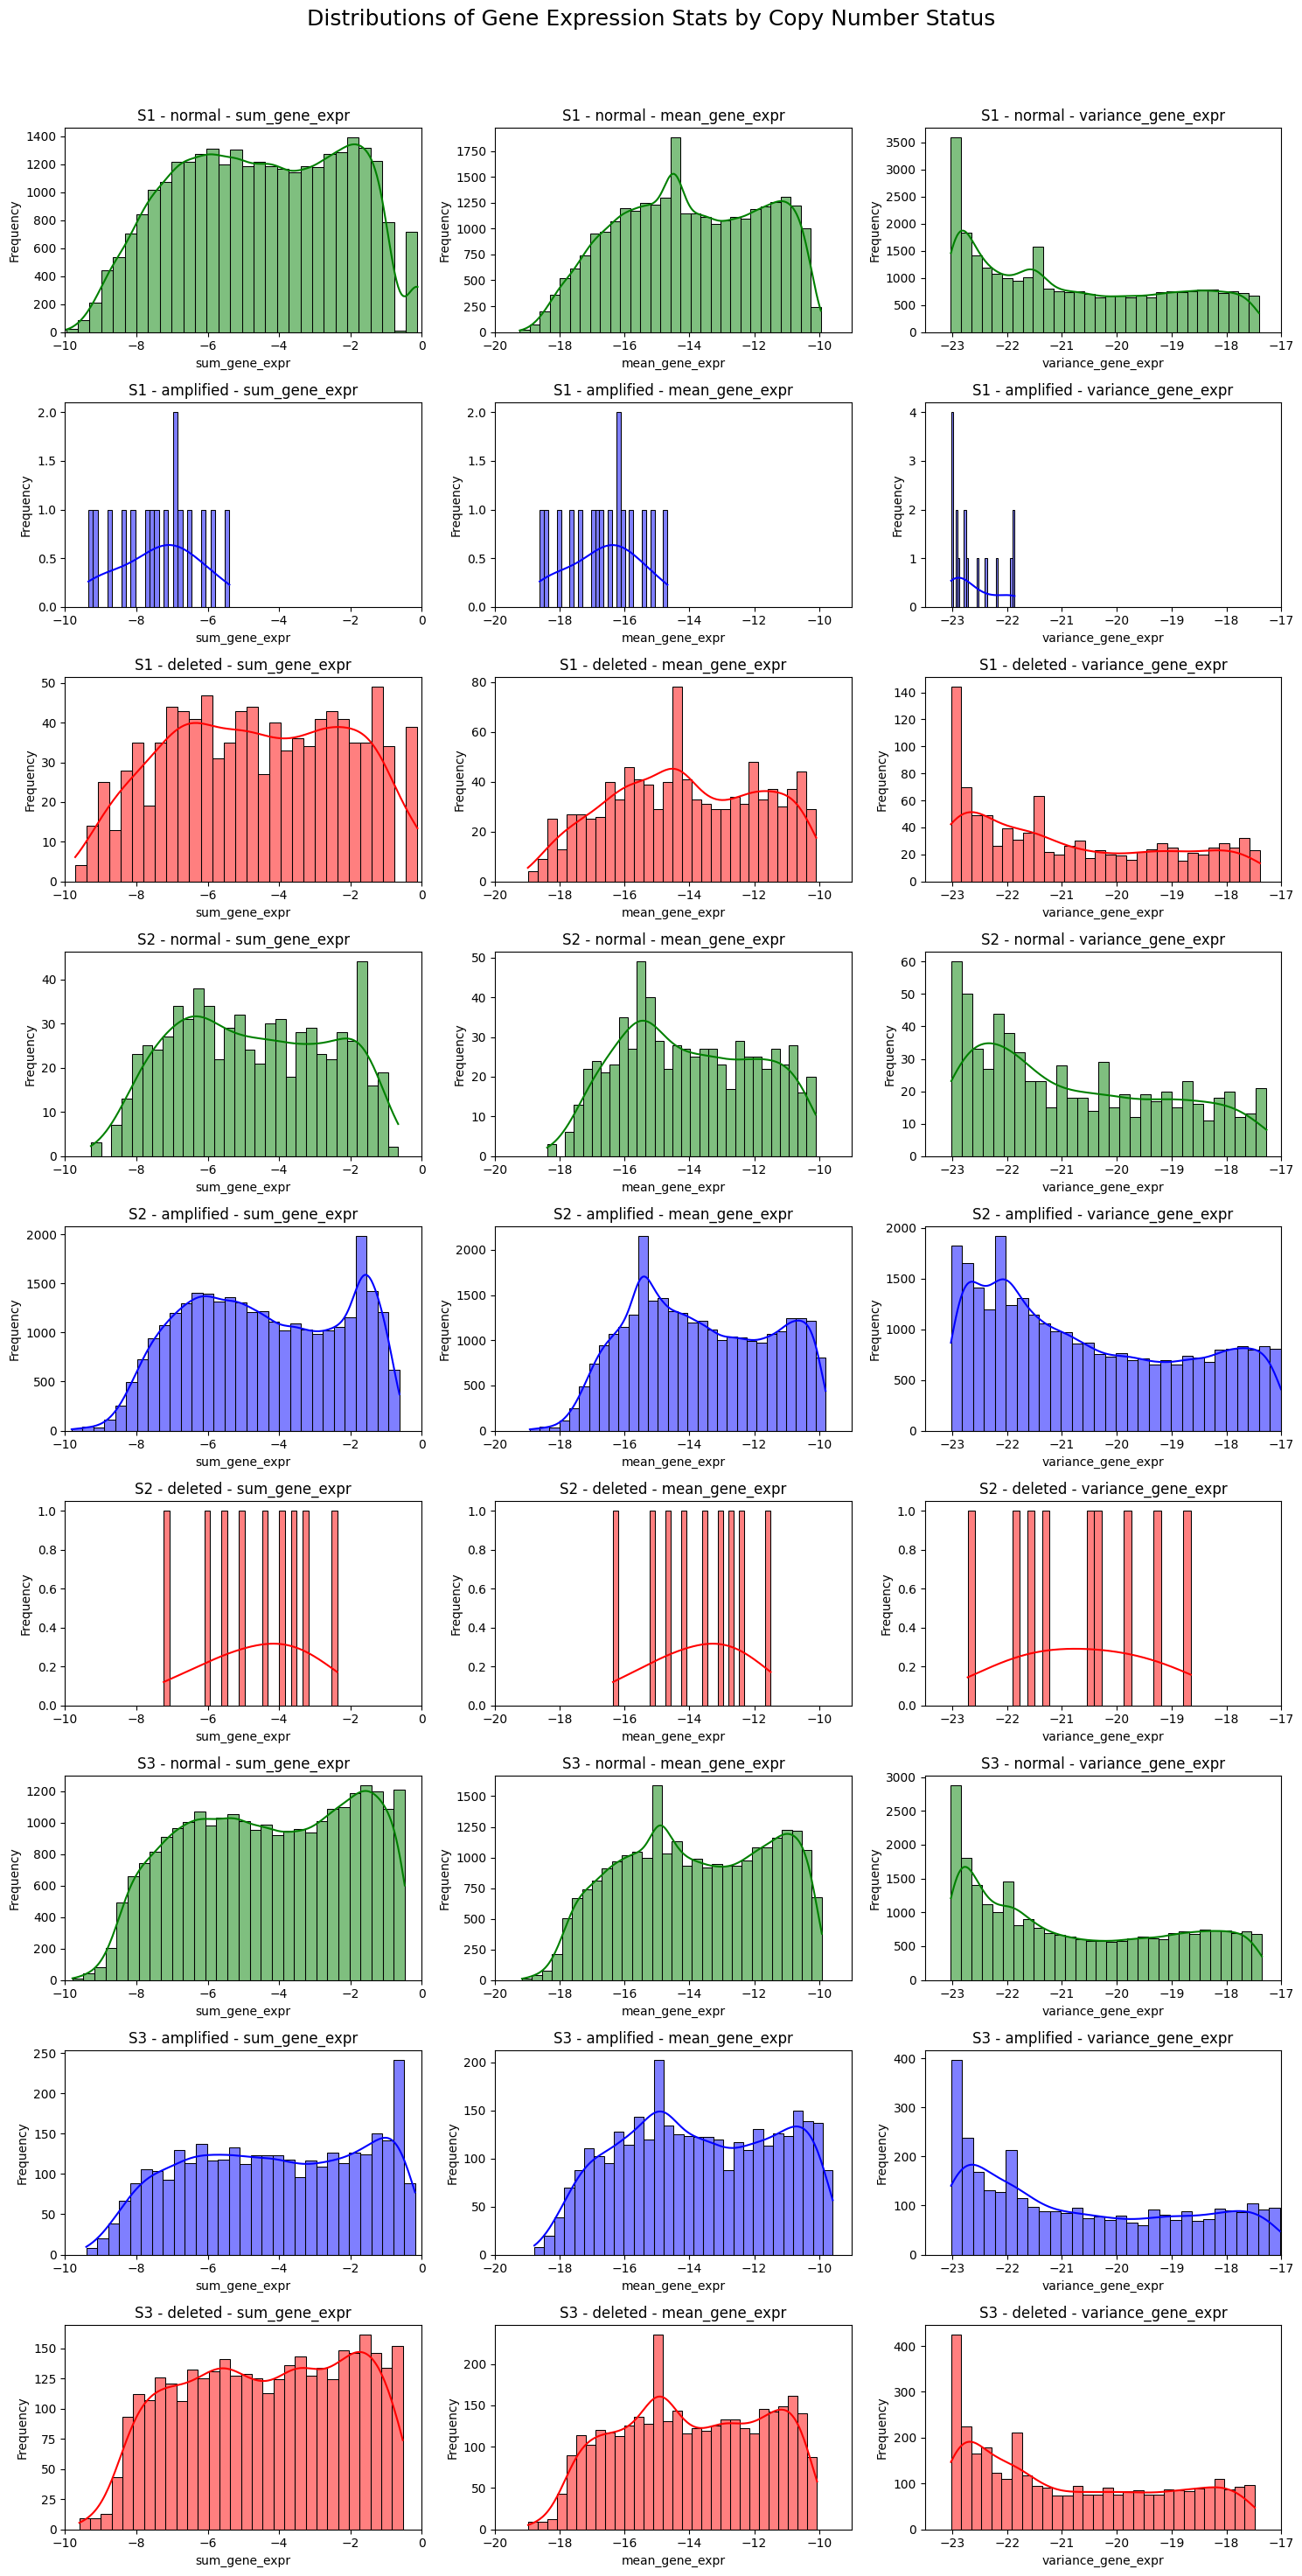

In [ ]:
split_stats = {} # dictionary to hold stats separated by CNV status

# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stats by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    for column in stats:
        norm_df_cleaned = norm_df.copy()
        norm_df_cleaned = remove_outliers_iqr(norm_df_cleaned, column)
        amp_df_cleaned = amp_df.copy()
        amp_df_cleaned = remove_outliers_iqr(amp_df_cleaned, column)
        del_df_cleaned = del_df.copy()
        del_df_cleaned = remove_outliers_iqr(del_df_cleaned, column)

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    status_dfs_cleaned = [norm_df_cleaned, amp_df_cleaned, del_df_cleaned]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs_cleaned, statuses)):
        for k, stat in enumerate(stats):
            data = np.log(status_df[stat] + 1e-10) # small constant for zero values
            split_stats[f'{sample_name}_{status}_{stat}'] = data

            ax = axes[i * 3 + j, k]
            sns.histplot(data, bins=30, kde=True, ax=ax, color=status_colors[status])
            ax.set_title(f"{sample_name.upper()} - {status} - {stat}")
            ax.set_xlabel(stat)
            ax.set_ylabel("Frequency")

            # hardcode x-axis limits based on the stat
            if stat == 'sum_gene_expr':
                ax.set_xlim(-10, 0)
            elif stat == 'mean_gene_expr':
                ax.set_xlim(-20, -9)
            elif stat == 'variance_gene_expr':
                ax.set_xlim(-23.5, -17)

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()

### K-S Tests: raw statistics

Two-sample K-S tests are used to compare distributions. Statistics from sample 3 are examined. Despite its class imbalance, it has a non-negligible amount of each class compared to other samples (of the chosen three in this notebook, and the dataset in general)

**Null hypothesis**: The samples have identical distributions ('two-sided' option for the `alternative` parameter)

**K-S Test output terms**:

`statistic`: Maximum distance between the two cumulative distribution functions (CDFs). Higher value --> greater divergence.

`pvalue`: Probability of observing the given statistic under the null hypothesis
- Low p-value (e.g., < 0.05) suggests the two distributions are significantly different.
- High p-value means the distributions are similar enough to not reject the null hypothesis.

`statistic_location`: Value in the dataset where the maximum difference (statistic) occurs. Helps show where the two distributions deviate the most.

`statistic_sign`:
- -1: Indicates the CDF of dataset 1 is *below* that of dataset 2 at statistic_location.
- 1: Indicates the CDF of dataset 1 is *above* that of dataset 2 at statistic_location.

**References**:

https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

#### Deleted vs non-deleted

In [ ]:
# sum comparison
ks_s3_sum_del_amp = ks_2samp(split_stats['s3_deleted_sum_gene_expr'], split_stats['s3_amplified_sum_gene_expr'], alternative='two-sided')
print(f"K-S test (SUM - del vs amp):\n{ks_s3_sum_del_amp}")

ks_s3_sum_del_norm = ks_2samp(split_stats['s3_deleted_sum_gene_expr'], split_stats['s3_normal_sum_gene_expr'], alternative='two-sided')
print(f"\nK-S test (SUM - del vs norm):\n{ks_s3_sum_del_norm}")

# mean comparison
ks_s3_mean_del_amp = ks_2samp(split_stats['s3_deleted_mean_gene_expr'], split_stats['s3_amplified_mean_gene_expr'], alternative='two-sided')
print(f"\nK-S test (MEAN - del vs amp):\n{ks_s3_mean_del_amp}")

ks_s3_mean_del_norm = ks_2samp(split_stats['s3_deleted_mean_gene_expr'], split_stats['s3_normal_mean_gene_expr'], alternative='two-sided')
print(f"\nK-S test (MEAN - del vs norm):\n{ks_s3_mean_del_norm}")

# variance comparison
ks_s3_variance_del_amp = ks_2samp(split_stats['s3_deleted_variance_gene_expr'], split_stats['s3_amplified_variance_gene_expr'], alternative='two-sided')
print(f"\nK-S test (VARIANCE - del vs amp):\n{ks_s3_variance_del_amp}")

ks_s3_variance_del_norm = ks_2samp(split_stats['s3_deleted_variance_gene_expr'], split_stats['s3_normal_variance_gene_expr'], alternative='two-sided')
print(f"\nK-S test (VARIANCE - del vs norm):\n{ks_s3_variance_del_norm}")

K-S test (SUM - del vs amp):
KstestResult(statistic=0.06594206538902016, pvalue=8.040266974800284e-07, statistic_location=-1.3182358532978198, statistic_sign=1)

K-S test (SUM - del vs norm):
KstestResult(statistic=0.02021745287827592, pvalue=0.16509976916698543, statistic_location=-3.0892665308270457, statistic_sign=1)

K-S test (MEAN - del vs amp):
KstestResult(statistic=0.06822111145902499, pvalue=2.858519968264337e-07, statistic_location=-10.710393175464189, statistic_sign=1)

K-S test (MEAN - del vs norm):
KstestResult(statistic=0.02680713194829165, pvalue=0.025079439657216818, statistic_location=-12.481401997117757, statistic_sign=1)

K-S test (VARIANCE - del vs amp):
KstestResult(statistic=0.0686765863472436, pvalue=2.3149126801688733e-07, statistic_location=-17.497254177263525, statistic_sign=1)

K-S test (VARIANCE - del vs norm):
KstestResult(statistic=0.024388490851116496, pvalue=0.05325929202224644, statistic_location=-19.490126771713967, statistic_sign=1)


**Observations**:
- **del vs amp** show higher `statistic` values (implies moderate difference) and very low `pvalue` (implies significant difference) across the three statistics.
- **del vs normal** show lower `statistic` values (implies small difference) and higher or moderate `pvalue` (implies no significant difference) which varies between different gene expression statistics.
- `statistic_location` being negative (recall that stats log-transformed for the plots) means maximum differences between distributions occur at small values of the gene expression stats (lower tail).
- The `statistic_sign` being 1 across all tests implies that the CDF of del is higher at point of greatest difference between the 2 distributions when comparing against both amp and norm. This means deleted examples have a higher frequency (density?) at this point of divergence.
- Based on `statistic` and `pvalue`, deleted statuses have significantly different distributions to amplified ones, while not differing as much from normal ones.
- Combining the facts that:
 - each `statistic_location` is at a notably small value (low gene expression)
 - `statistic_sign` is always 1 (CDF for deleted status is ahead/higher compared to that of other statuses)

 this implies that the distribution for deleted examples is skewed towards smaller gene expression values relative to normal or amplified examples. Overall lower gene expression?!

#### Normal vs amplified

In [ ]:
# sum comparison
ks_s3_sum_norm_amp = ks_2samp(split_stats['s3_normal_sum_gene_expr'], split_stats['s3_amplified_sum_gene_expr'])
print(f"K-S test (SUM - norm vs amp):\n{ks_s3_sum_norm_amp}")

# mean comparison
ks_s3_mean_norm_amp = ks_2samp(split_stats['s3_normal_mean_gene_expr'], split_stats['s3_amplified_mean_gene_expr'])
print(f"\nK-S test (MEAN - norm vs amp):\n{ks_s3_mean_norm_amp}")

# variance comparison
ks_s3_variance_norm_amp = ks_2samp(split_stats['s3_normal_variance_gene_expr'], split_stats['s3_amplified_variance_gene_expr'])
print(f"\nK-S test (VARIANCE - norm vs amp):\n{ks_s3_variance_norm_amp}")

K-S test (SUM - norm vs amp):
KstestResult(statistic=0.0544512131485686, pvalue=5.3707303414384816e-08, statistic_location=-0.9947856960728862, statistic_sign=1)

K-S test (MEAN - norm vs amp):
KstestResult(statistic=0.04940413573532332, pvalue=1.169227245889512e-06, statistic_location=-10.386944256725776, statistic_sign=1)

K-S test (VARIANCE - norm vs amp):
KstestResult(statistic=0.05074739049548893, pvalue=5.303310401141318e-07, statistic_location=-17.48843742986055, statistic_sign=1)


**Observations**:
- When comparing norm vs amp examples, `statistic` and `pvalue` are closer across all stats.
- `statistic` ranges from ~0.049 to ~0.054, which is a high enough value to consider the norm and amp distributions to be different.
- This is supported by the significantly `pvalue`, which more concretely shows a difference by being small enough to reject the null hypothesis.
- `statistic_location` values are once again all negative, with that of the sum test being closest to 0.
- `statistic_sign` is again 1 across the board, showing that for each test, the CDF for normal statuses is higher than that of amplified at their point of greatest difference.
- This information implies a similar trend as discussed above, except that normal examples tend toward lower gene expression stat values compared to amplified.

Overall, gene expression does seem to form patterns based on the copy number variation status, where expression value follows:

deleted < normal < amplified

## Deviance of statistics compared to mean over other samples

Note that x-axes are not fixed like the histograms above because the high variation within ranges of small numbers does not allow for fixed axes to showcase all distributions properly. For example, some mean deviation variation distributions are on a 1e-10 scale while others are around 1e-8 values. Fixing ranges makes it more difficult to view at all when comparing across CNV statuses.

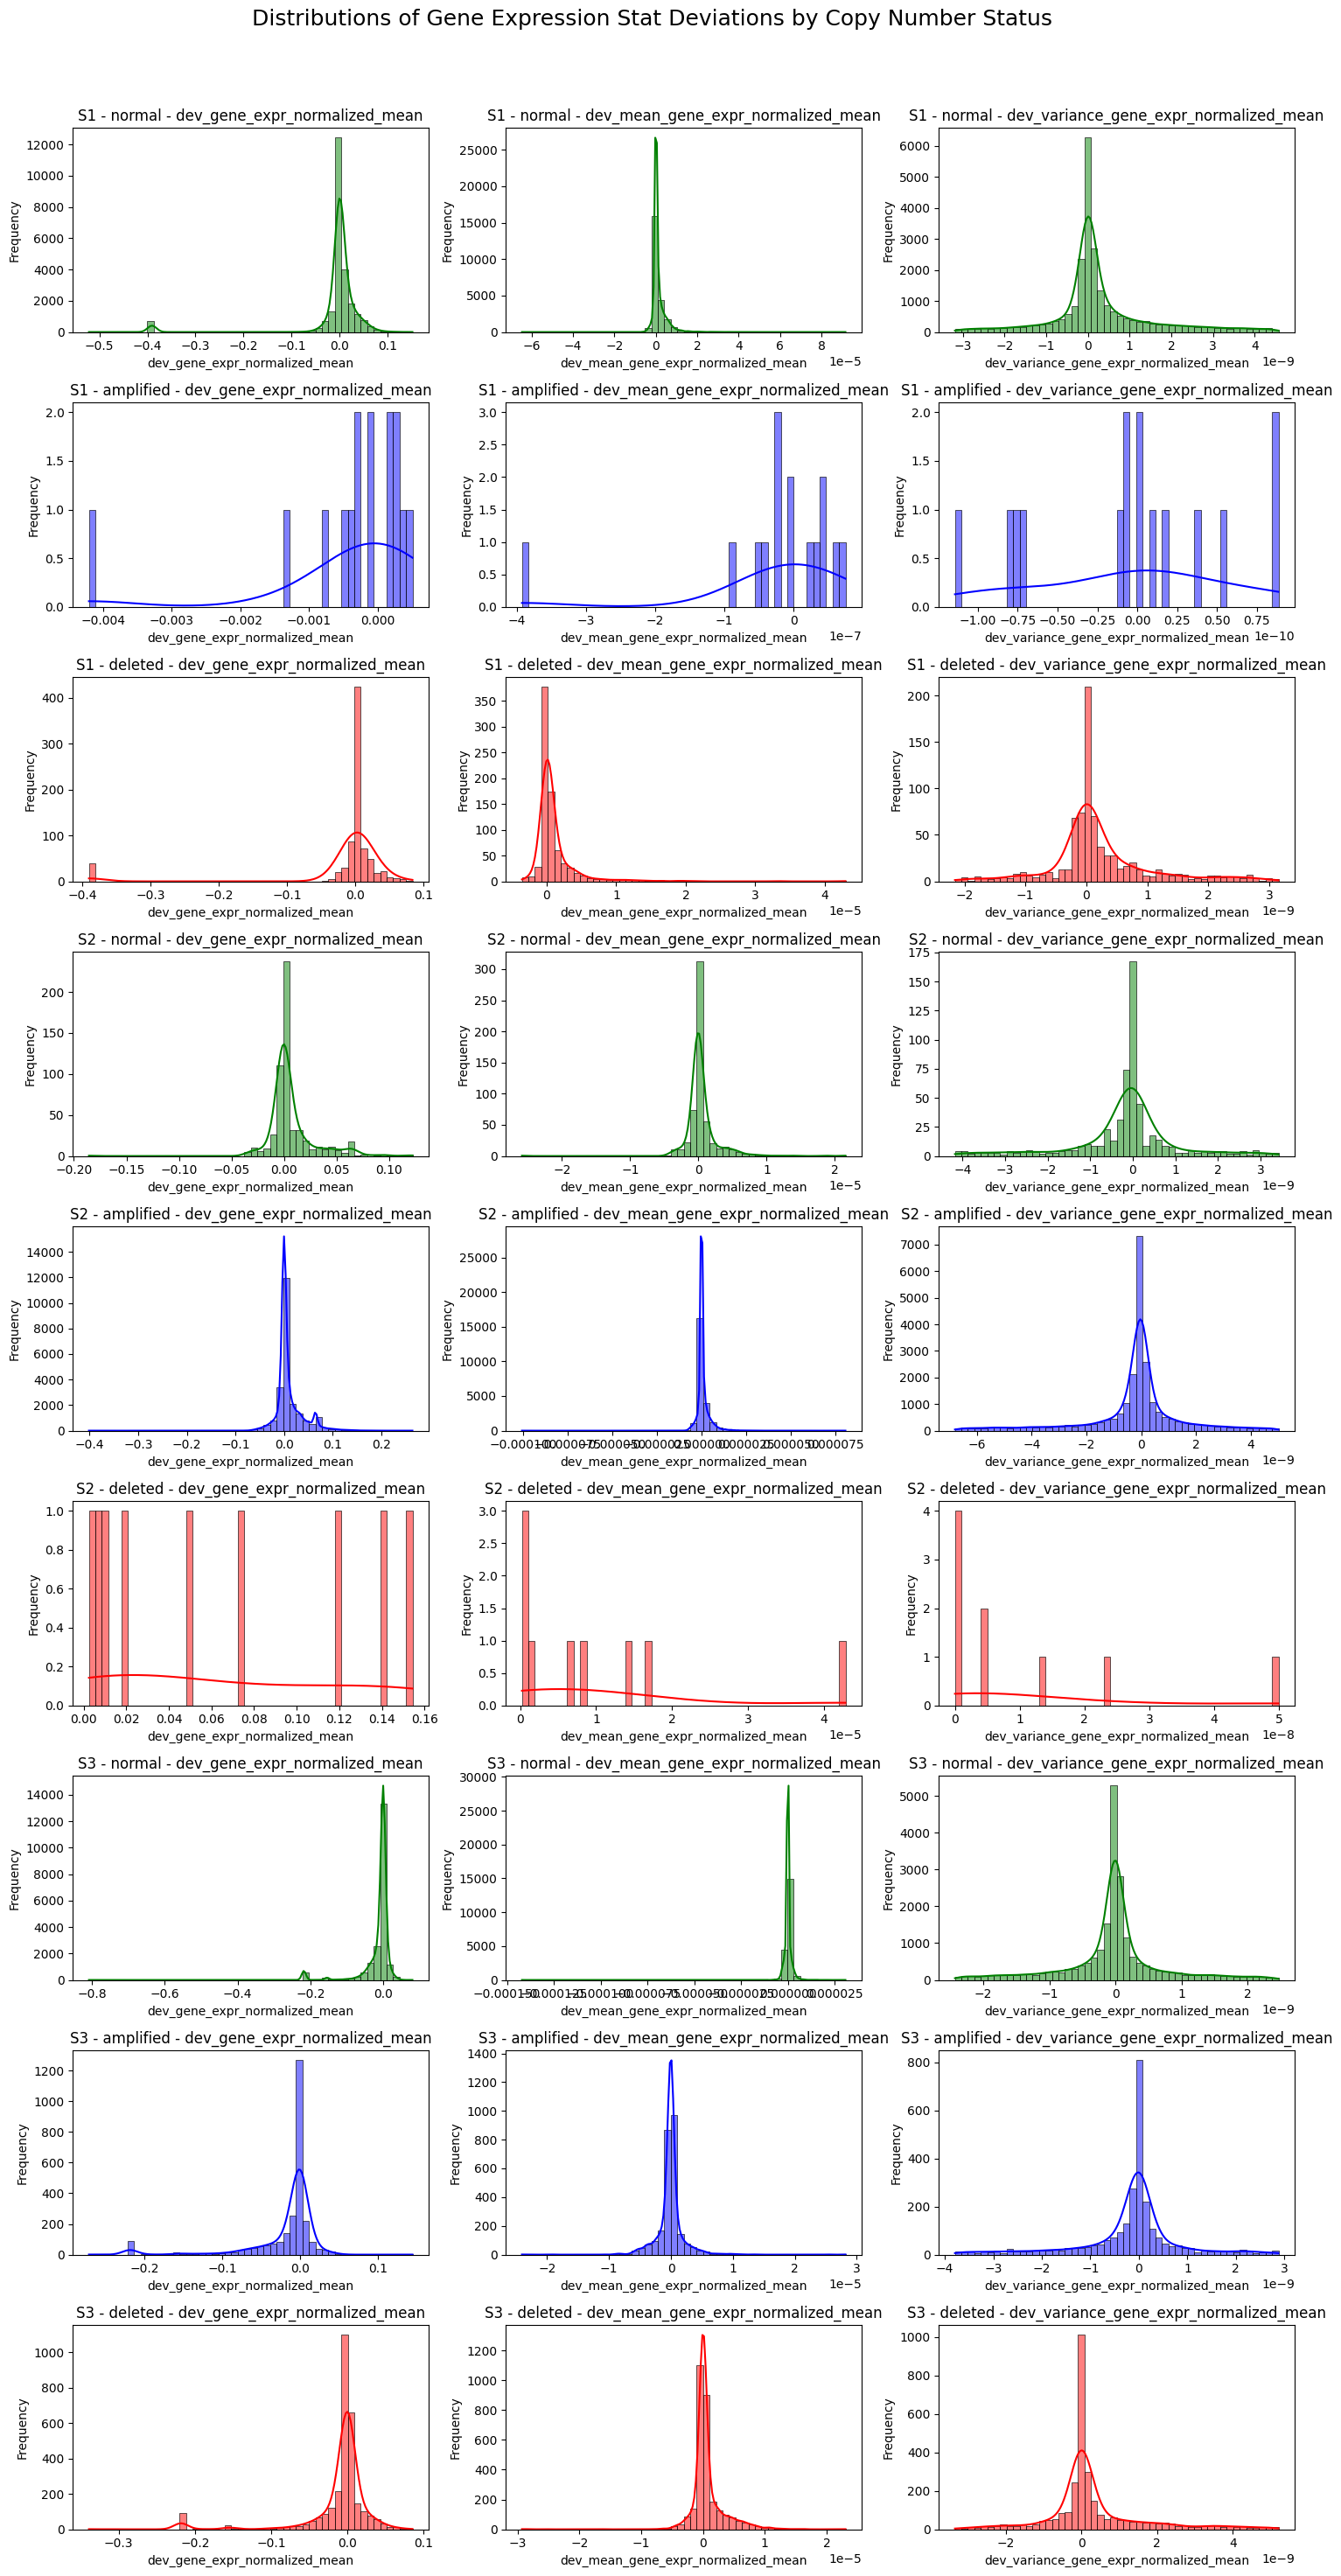

In [5]:
split_dev_stats = {} # dictionary to hold stats separated by CNV status

# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stat Deviations by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    for column in dev_stats:
        norm_df_cleaned = norm_df.copy()
        norm_df_cleaned = remove_outliers_iqr(norm_df_cleaned, column)
        amp_df_cleaned = amp_df.copy()
        amp_df_cleaned = remove_outliers_iqr(amp_df_cleaned, column)
        del_df_cleaned = del_df.copy()
        del_df_cleaned = remove_outliers_iqr(del_df_cleaned, column)

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    status_dfs_cleaned = [norm_df_cleaned, amp_df_cleaned, del_df_cleaned]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs_cleaned, statuses)):
        for k, stat in enumerate(dev_stats):
            data = status_df[stat]
            split_dev_stats[f'{sample_name}_{status}_{stat}'] = data

            sns.histplot(data, bins=50, kde=True, ax=axes[i * 3 + j, k], color=status_colors[status])
            axes[i * 3 + j, k].set_title(f"{sample_name.upper()} - {status} - {stat}")
            axes[i * 3 + j, k].set_xlabel(stat)
            axes[i * 3 + j, k].set_ylabel("Frequency")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()

### K-S Tests: deviance from mean across samples

Sample 3 is again used here, but the only statistic being compared between CNV statuses is the deviation of mean gene expression from the mean over all other samples (patients). This is the middle column of the plot grid.



In [ ]:
# deleted vs amplified
ks_s3_mean_del_amp = ks_2samp(split_dev_stats['s3_deleted_dev_mean_gene_expr_normalized_mean'], split_dev_stats['s3_amplified_dev_mean_gene_expr_normalized_mean'])
print(f"K-S test (MEAN - del vs amp):\n{ks_s3_mean_del_amp}")

# deleted vs normal
ks_s3_mean_del_norm = ks_2samp(split_dev_stats['s3_deleted_dev_mean_gene_expr_normalized_mean'], split_dev_stats['s3_normal_dev_mean_gene_expr_normalized_mean'])
print(f"\nK-S test (MEAN - del vs norm):\n{ks_s3_mean_del_norm}")

# normal vs amplified
ks_s3_mean_norm_amp = ks_2samp(split_dev_stats['s3_normal_dev_mean_gene_expr_normalized_mean'], split_dev_stats['s3_amplified_dev_mean_gene_expr_normalized_mean'])
print(f"\nK-S test (MEAN - norm vs amp):\n{ks_s3_mean_norm_amp}")

K-S test (MEAN - del vs amp):
KstestResult(statistic=0.1446107510356378, pvalue=8.272131123382322e-26, statistic_location=1.231786261765532e-09, statistic_sign=-1)

K-S test (MEAN - del vs norm):
KstestResult(statistic=0.11029110803637121, pvalue=7.130125001104651e-28, statistic_location=1.124612454574873e-07, statistic_sign=-1)

K-S test (MEAN - norm vs amp):
KstestResult(statistic=0.05092352869497979, pvalue=1.1611388481984482e-05, statistic_location=-6.912726489893477e-08, statistic_sign=-1)


**Observations**:
- `statistic` values are quite high (~0.1) for the comparison of del vs amp and del vs norm, showing a large difference between their distributions. Norm vs amp shows a lower `statistic`, implying a smaller difference.
- All returned values of `pvalue` are low, extremely so for the comparison of del against the other statuses. Paired with the high `statistic` value, this indicates that the distribution of mean deviation for deleted statuses is vastly different from the others.
- `statistic_location` places the point of greatest difference at small mean deviation values.
- `statistic_sign` is -1 for each, showing that between all test pairs, distributions are ordered del < norm < amp in terms of CDF at the point of max difference.

**Deleted vs amplified**: highly significant difference between distributions where amp has a higher cumulative proportion of points below this value, suggesting that amp has more small mean deviation values compared to del.

**Deleted vs normal**: highly significant difference between distributions, where a similar conclusion can be drawn; norm has smaller mean deviations compared to del.

**Normal vs amplified**: significant enough difference between distributions where amp has smaller mean deviations compared to del.

Least to greatest deviation in mean gene expression from overall (cross-sample) mean:

amplified < normal < deleted

Potential issue of class imbalance showing here; initially predicted that normal would have the smallest deviations as the dominant class?